# 06 - FWI with total variation (TV) minimization as constraints

## Introduction

There is a lot of research on regularization to improve the quality of the final result beyond the simple box constraints implemented in the previous tutorials. In this tutorial we look at how more advanced FWI techniques such as [total variation denoising]( https://en.wikipedia.org/wiki/Total_variation_denoising) applied as a constraint can be implemented using [Devito](http://www.opesci.org/devito-public) and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) using [scikit-image](http://scikit-image.org/). This is a variant of the FWI with TV constrains algorithm described in [Peters and Herrmann 2017](https://doi.org/10.1190/tle36010094.1).

[Dask](https://dask.pydata.org/en/latest/#dask) is also used here to speed up the examples.

This tutorial uses the same synthetic datasets and model setup as the previous two tutorals, so check back if you get lost on parts of the code specific to Devito, SciPy.optimize or Dask. 

## Setting up (synthetic) data
We are going to set up the same synthetic test case as for the previous tutorial (refer back for details).

In [1]:
#NBVAL_IGNORE_OUTPUT
from devito import Grid

import scipy
from scipy import signal

import numpy as np
import distributed
import cloudpickle as pickle

from examples.seismic import Model, demo_model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import RickerSource, Receiver

from skimage.restoration import denoise_tv_chambolle as denoise

def get_shape():
    '''Number of grid point (nx, nz).
    '''
    shape = (101, 101)
    return shape

def get_spacing():
    '''Grid spacing in m. The domain size is now 1km by 1km.
    '''
    spacing = (10., 10.)
    return spacing

def get_origin():
    '''Need origin to define relative source and receiver locations.
    '''
    origin = (0., 0.)
    return origin

def get_nbpml():
    '''Get nbpml thickness.
    '''
    return 40

def get_true_model():
    ''' Define the test phantom; in this case we are using
    a simple circle so we can easily see what is going on.
    '''
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=get_origin(), shape=get_shape(),
                      spacing=get_spacing(), nbpml=get_nbpml())

def get_initial_model():
    '''The initial guess for the subsurface model.
    '''
    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=get_origin(), shape=get_shape(),
                      spacing=get_spacing(), nbpml=get_nbpml())

def wrap_model(x, astype=None):
    '''Wrap a flat array as a subsurface model.
    '''
    model = get_initial_model()
    if astype:
        model.m.data[:] = x.astype(astype).reshape(model.m.data.shape)
    else:
        model.m.data[:] = x.reshape(model.m.data.shape)
    return model

def get_current_model(param):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """
    model = wrap_model(np.load(param['model']))
    return model

def dump_shot_data(shot_id, src, rec):
    ''' Dump shot data to disk.
    '''
    print ("shot_id = ", shot_id)
    # Should src.data be pickled also?
    pickle.dump({'name':src.name,
                 'f0':src.f0,
                 'grid_extent':src.grid.extent,
                 'grid_shape':src.grid.shape,
                 'grid_dimensions':src.grid.dimensions,
                 'data':src.data,
                 'time':src.time,
                 'coordinates':src.coordinates.data},
                open("shot_src_%d.p"%shot_id, "wb"))

    pickle.dump({'name':rec.name,
                 'grid_extent':rec.grid.extent,
                 'grid_shape':rec.grid.shape,
                 'grid_dimensions':rec.grid.dimensions,
                 'data':rec.data,
                 'ntime':rec.ntime,
                 'coordinates':rec.coordinates.data},
                open('shot_rec_%d.p'%shot_id, "wb"))

def load_shot_data(shot_id):
    ''' Load shot data from disk.
    '''
    pkl = pickle.load(open("shot_src_%d.p"%shot_id, "rb"))
    pkl_grid = Grid(extent=pkl['grid_extent'],
                    shape=pkl['grid_shape'],
                    dimensions=pkl['grid_dimensions'])
    src = RickerSource(name=pkl['name'], grid=pkl_grid,
                       f0=pkl['f0'], time=pkl['time'],
                       coordinates=pkl['coordinates'])
    src.data[:] = pkl['data']
    
    rpkl = pickle.load(open("shot_rec_%d.p"%shot_id, "rb"))
    rec = Receiver(name=rpkl['name'], grid=pkl_grid,
                   data=rpkl['data'], coordinates=rpkl['coordinates'])

    return src, rec

def resample(src, rec, dt):
    dt_orig = src.time[1]-src.time[0]
    
    nt_new = int(round((src.time[-1]-src.time[0])/dt))
    dt_new = (src.time[-1]-src.time[0])/nt_new # Roundoff correction
    
    # Create resampled source
    src_new = RickerSource(name=src.name, grid=src.grid, f0=src.f0,
                           time=np.array([i*dt_new for i in range(nt_new)]),
                           coordinates=src.coordinates.data)
    src_new.data[:] = scipy.signal.resample(src.data, nt_new)
    
    # Create resampled receiver.
    rec_data = np.zeros((nt_new, rec.data.shape[1]))
    for i in range(rec.data.shape[1]):
        rec_data[:, i] = scipy.signal.resample(rec.data[:, i], nt_new)
    rec_new = Receiver(name=rec.name, grid=rec.grid,
                       data=rec_data, coordinates=rec.coordinates.data)
        
    return src_new, rec_new

In [2]:
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    true_model = get_true_model()
    shot_id = param['shot_id']
    
    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Set up source data and geometry.
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    # Add padding
    tn = (nt-1)*dt
    
    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'],
                       time=np.linspace(param['t0'], tn, nt))
    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]
    
    # Number of receiver locations per shot.
    nreceivers = 101

    # Set up receiver data and geometry.
    rec = Receiver(name='rec', grid=true_model.grid, npoint=nreceivers, ntime=nt)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver 
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    dump_shot_data(shot_id, src, true_d)

def generate_shotdata(param):
    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Start dask cluster
    client = distributed.Client()
    
    # Map worklist to cluster
    futures = client.map(generate_shotdata_i, work)
    distributed.wait(futures)

    # Shutdown cluster
    client.close()

In [3]:
# Define a type to store the functional and gradient.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

from devito import Function, clear_cache

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):
    # Need to clear the workers cache.
    clear_cache()

    # Load the current model and the shot data for this worker.
    model0 = get_current_model(param)
    
    dt = model0.critical_dt

    src, rec = resample(*load_shot_data(param['shot_id']), dt)
    
    solver = AcousticWaveSolver(model0, src, rec, space_order=4)
    
    # Correct dt - gets modified by resample
    solver.dt = src.time[1]-src.time[0]

    # Create symbols to hold the gradient and the mismatch between
    # the 'measured' and simulated data.
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='rec', grid=model0.grid, ntime=len(src.time),
                        coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data mismatch (residual) and objective function  
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropogates the data mismatch through the model.
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Taking here to avoid a (probably overzealous) destructor deleting
    # the gradient before Dask has had a chance to communicate it.
    g = np.array(grad.data[:])
        
    # return the objective functional and gradient.
    return fg_pair(f, g)

# Dumps the model to disk; workers will pick this up when they need it.
def dump_model(param, model):
    np.save(param['model'], model.astype(np.float32))

# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum accepted velocity is 3.5 km/sec (true is 3 km/sec)
    # Minimum accepted velocity is 2 km/sec (true is 2.5 km/sec)
    return np.clip(m, 1/3.5**2, 1/2**2)

def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.npy"
    dump_model(param, model)

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Start dask cluster
    client = distributed.Client()
    
    # Map worklist to cluster
    fgi = client.map(fwi_gradient_i, work)
    
    # Perform reduction on cluster
    fg = client.submit(sum, fgi).result()
    
    # Shutdown cluster
    client.close()

    # Is the order of constraints important? How should they be relaxed?
    
    # Treat the surface layer as 'known'. When should this really be applied?
    # fg.g[0:65,:] = 0. # adding the boundary padding.
    # fg.g[-65:,:] = 0.

    # TV applied to gradient
    m = wrap_model(model).m.data
    m_tv = denoise(m - fg.g, weight=param['tv_weight'])
    
    # Appears to be far too severe if box constraint applied in this manner.
    # g_tv = m - apply_box_constraint(m_tv)
    g_tv = m - m_tv

    return fg.f, g_tv.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [4]:
from scipy import optimize

# Many methods in scipy.optimize.minimize allow us to define a callback
# function that can operate on the solution after every iteration. Here
# we use this to apply box constraints and to monitor the true relative
# solution error.
relative_error = []
def fwi_callbacks(x):
    # Calculate true relative error
    true_x = get_true_model().m.data.flatten()
    relative_error.append(np.linalg.norm((x-true_x)/true_x))
    
    print(relative_error[-1])

def fwi(model, param, ftol=1e-12, maxiter=1000):
    result = optimize.minimize(fwi_gradient,
                               model.m.data.flatten().astype(np.float64),
                               args=(param, ),
                               method='L-BFGS-B',
                               jac=True,
                               callback=fwi_callbacks,
                               options={'ftol':ftol,
                                        'maxiter':maxiter,
                                        'disp':True})
    
    return result

We new apply our FWI function and have a look at the result.

In [5]:
# Create all the dataAdjust the level of diagnostic output from Devito
from devito import configuration
configuration['log_level'] = 'WARNING'

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation last 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 3,              # Number of shots to create gradient from
         'tv_weight' : 5e-3}

generate_shotdata(param)

In [6]:
#NBVAL_SKIP

model0 = get_initial_model()

# Apply FWI with TV.
result = fwi(model0, param, ftol=1e-2)

# Print out results of optimizer.
print(result)

model0 = wrap_model(result.x)

9.21739122215
8.99332755843
8.53619103924
7.90943939211
7.32077939025
7.06381020811
6.88631381645
6.66015520766
6.5854900265
6.58098267302
6.55928892831
6.50903346795
6.44559007614
6.36363531475
6.3251903402
6.32690657564
6.32074840453
6.2819559562
6.24843393338
6.2078705843
6.17371859355
6.12853354898
6.12137548325
6.1156085999
6.08977961223
6.0333975696
5.97911943207
5.95286972594
5.9298924826
5.8978720896
5.89376396251
5.87931222348
5.85634073187
5.81519819054
5.7308566079
5.74219281925
5.73818405446
5.70967576142
5.65019826923
5.62055611559
5.57437143227
5.5523369307
5.52545986657
5.51010231154
5.49261120617
5.47116952589
5.452869644
5.41392551911
5.39155276446
5.35953488232
5.33295985937
5.29200524209
5.22512410735
5.22112179991
5.21565848887
5.19650125329
5.16259819887
      fun: 1.890238246387014
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     

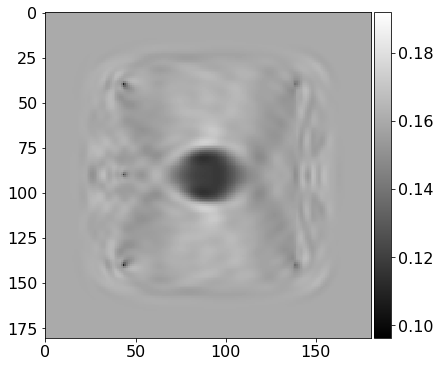

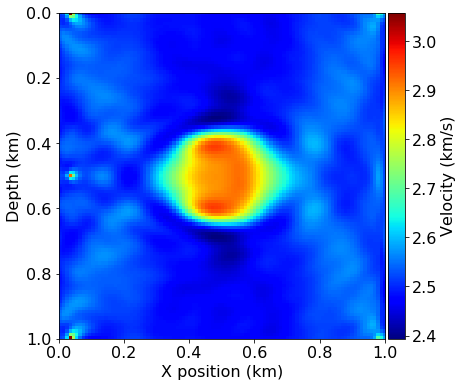

In [7]:
#NBVAL_SKIP

# Show what the update does to the model
from examples.seismic import plot_image, plot_velocity
plot_image(model0.m.data)
model0.vp = np.sqrt(1. / model0.m.data[40:-40, 40:-40])
plot_velocity(model0)

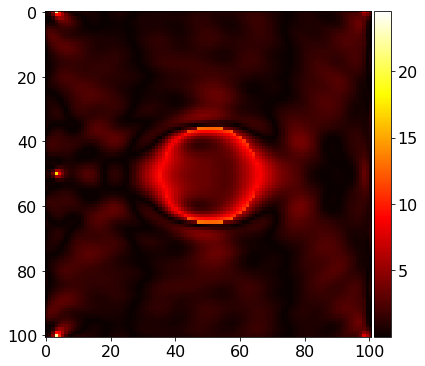

In [8]:
#NBVAL_SKIP

# Plot percentage error
plot_image(100*np.abs(model0.vp-get_true_model().vp.data)/get_true_model().vp.data, cmap="hot")

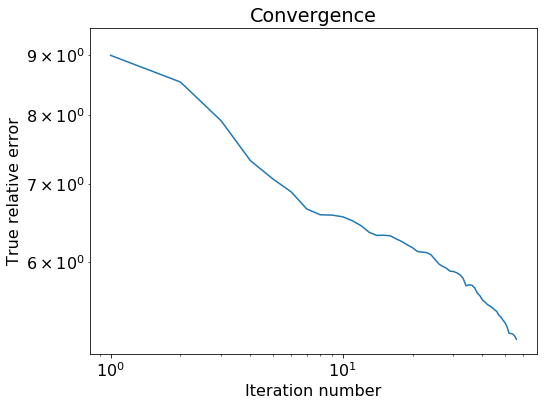

In [9]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_error)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()